# Import Libraries

In [47]:
import warnings

warnings.simplefilter(action ='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from PIL import Image

import matplotlib.pyplot as plt
import os
import PIL
import shutil
import random
import glob
import itertools

%matplotlib inline


# Load Data

In [2]:
meta_data = pd.read_csv("/kaggle/input/skin-cancer-dataset/HAM10000_metadata.csv")
meta_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
print("Unique Cancer types represented in data")
print(meta_data.dx.unique(),"\n")

# Handling categorical data
encoder = LabelEncoder()
meta_data["dx_label"] = encoder.fit_transform(meta_data["dx"])

# Display of labels and their integer encoding
print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data
['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec'] 

Cancer types and their integer encoding
['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [4]:
image_dir_path = '/kaggle/input/skin-cancer-dataset/Skin Cancer/Skin Cancer/'

# Get a list of all files in the directory
files = os.listdir(image_dir_path)

# Filter out only the image files
image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]

# Count the number of image files
num_images = len(image_files)

print("Number of images:", num_images)

Number of images: 10015


# Data Cleaning

In [5]:
# Define training directory
train_dir = "/kaggle/working/training_set"

# Create directory if they do not exist
os.makedirs(train_dir, exist_ok=True)

In [6]:
# Group images by cancer type
cancer_types = meta_data["dx"].unique()

# Copy images to separated directories based on cancer type
for cancer_type in cancer_types:
    # Create a directory for the current cancer type within the train directory
    cancer_train_dir = os.path.join(train_dir, cancer_type)
    os.makedirs(cancer_train_dir, exist_ok=True)
    
    # Filter images corresponding to the current cancer type
    images_of_cancer_type = meta_data[meta_data["dx"] == cancer_type]["image_id"].values
    
    # Copy images to the directory for the current cancer type
    for image_id in images_of_cancer_type:
        image_file = image_id + ".jpg"  # Assuming all image files have '.jpg' extension
        source_path = os.path.join(image_dir_path, image_file)
        destination_path = os.path.join(cancer_train_dir, image_file)
        shutil.copy(source_path, destination_path)

In [7]:
# Get the list of subdirectories within the train directory
subdirs = [subdir for subdir in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, subdir))]

# Print the subdirectories and count of images in each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    num_images = len(os.listdir(subdir_path))
    print(f"Subdirectory: {subdir}, Number of Images: {num_images}")

Subdirectory: bcc, Number of Images: 514
Subdirectory: df, Number of Images: 115
Subdirectory: akiec, Number of Images: 327
Subdirectory: vasc, Number of Images: 142
Subdirectory: mel, Number of Images: 1113
Subdirectory: bkl, Number of Images: 1099
Subdirectory: nv, Number of Images: 6705


# Data Visualization

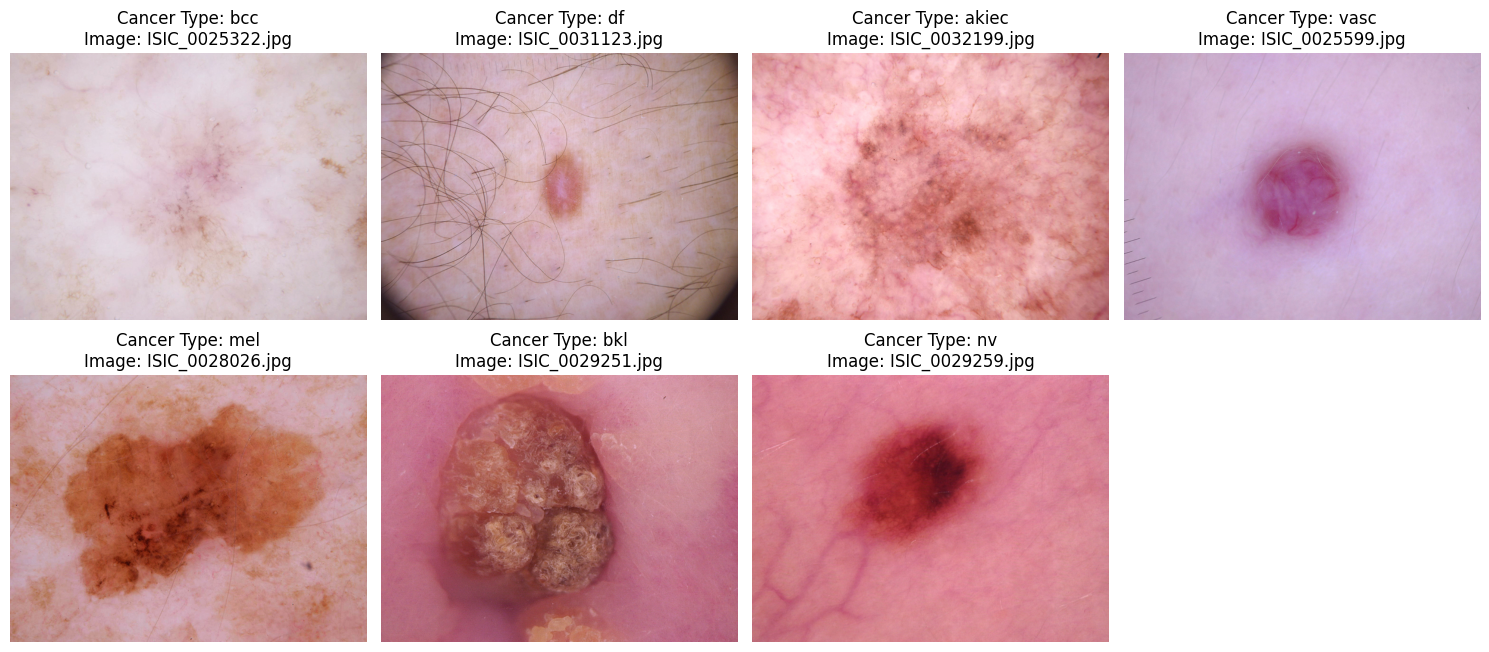

In [8]:
# Create a subplot for each subdirectory
plt.figure(figsize=(15, 10))
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(train_dir, subdir)
    # Get the list of image files in the subdirectory
    image_files = [file for file in os.listdir(subdir_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
    # Select the first image from the subdirectory
    if image_files:
        first_image_path = os.path.join(subdir_path, image_files[0])
        image = Image.open(first_image_path)
        # Plot the image
        plt.subplot(3, 4, i+1)  # Adjust the subplot parameters as needed
        plt.imshow(image)
        plt.title(f"Cancer Type: {subdir}\nImage: {image_files[0]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [9]:
# Define the image size and batch size
image_size = (224, 224)
batch_size = 32

# Create an ImageDataGenerator for preprocessing
datagen = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input)

# Create the train_batches using flow_from_directory
train_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['akiec', 'mel', 'nv', 'bcc', 'df', 'vasc', 'bkl']
)

# Create the test_batches using flow_from_directory
test_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['akiec', 'mel', 'nv', 'bcc', 'df', 'vasc', 'bkl']
)

# Create the valid_batches using flow_from_directory
valid_batches = datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    classes=['akiec', 'mel', 'nv', 'bcc', 'df', 'vasc', 'bkl']
)

Found 10015 images belonging to 7 classes.
Found 10015 images belonging to 7 classes.
Found 10015 images belonging to 7 classes.


In [10]:
assert train_batches.n == 10015

In [11]:
# Seperate labels with images for training data
imgs, labels = next(train_batches)

# Build and Train CNN 

In [12]:

model = Sequential([
    Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2), strides=2),
    
    Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), strides=2),
    
    Flatten(),
    
    Dense(units=7, activation='softmax'),
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │     1,404,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,424,455 (5.43 MB)

 Trainable params: 1,424,391 (5.43 MB)

 Non-trainable params: 64 (256.00 B)

In [14]:
model.compile(optimizer= Adam(learning_rate = 0.0001),
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
model.fit(
  x=train_batches,
  validation_data=valid_batches,
  epochs=10,
  verbose=2
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


313/313 - 897s - 3s/step - accuracy: 0.6753 - loss: 1.1838 - val_accuracy: 0.7525 - val_loss: 0.7546
Epoch 2/10
313/313 - 919s - 3s/step - accuracy: 0.7707 - loss: 0.6482 - val_accuracy: 0.8469 - val_loss: 0.4510
Epoch 3/10
313/313 - 887s - 3s/step - accuracy: 0.8240 - loss: 0.4884 - val_accuracy: 0.8460 - val_loss: 0.4204
Epoch 4/10
313/313 - 853s - 3s/step - accuracy: 0.8705 - loss: 0.3751 - val_accuracy: 0.8594 - val_loss: 0.3882
Epoch 5/10
313/313 - 860s - 3s/step - accuracy: 0.9078 - loss: 0.2801 - val_accuracy: 0.9329 - val_loss: 0.2086
Epoch 6/10
313/313 - 864s - 3s/step - accuracy: 0.9302 - loss: 0.2123 - val_accuracy: 0.9217 - val_loss: 0.2479
Epoch 7/10
313/313 - 918s - 3s/step - accuracy: 0.9496 - loss: 0.1632 - val_accuracy: 0.9783 - val_loss: 0.0887
Epoch 8/10
313/313 - 862s - 3s/step - accuracy: 0.9738 - loss: 0.1046 - val_accuracy: 0.9916 - val_loss: 0.0652
Epoch 9/10
313/313 - 864s - 3s/step - accuracy: 0.9797 - loss: 0.0816 - val_accuracy: 0.9897 - val_loss: 0.0544
Epo

# Model Evaluation

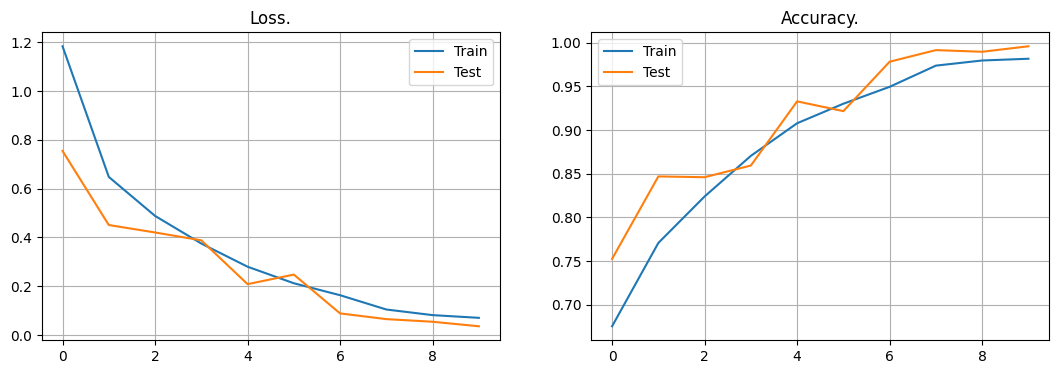

In [17]:
# Extracting metrics
metrics = model.history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_accuracy"]

# Visualizing metrics
plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train");
plt.plot(test_loss, label = "Test");
plt.grid(True)
plt.legend(loc = "best");

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train");
plt.plot(test_accuracy, label = "Test");
plt.grid(True)
plt.legend(loc = "best");

# Model Prediction

In [19]:
predictions = model.predict(x=test_batches, verbose=0)

In [21]:
np.round(predictions)

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

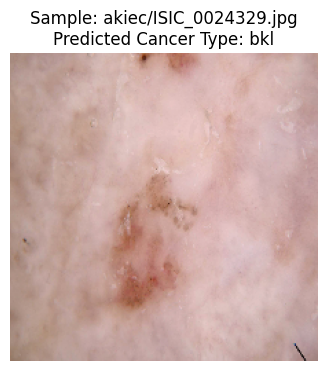

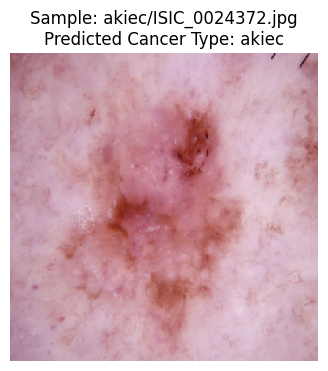

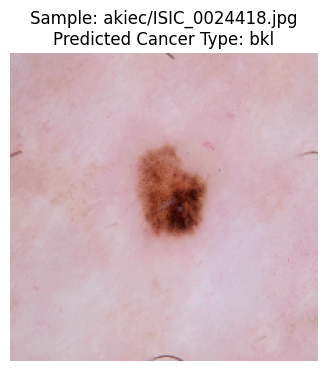

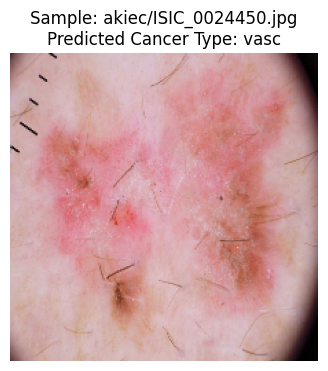

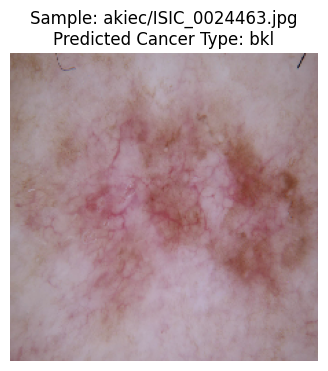

In [64]:
# Directory containing the images
image_dir = "/kaggle/working/training_set"  

# Iterate over the first 5 samples
for i in range(5):
    # Get the cancer type prediction for the ith sample
    predicted_cancer_index = np.argmax(predictions[i])
    predicted_cancer = cancer_types[predicted_cancer_index]
    
    # Get the name of the ith sample from test_batches
    sample_name = test_batches.filenames[i]
    
    # Load the image
    img_path = image_dir + "/" + sample_name
    img = image.load_img(img_path, target_size=(224, 224))  # Adjust target_size as per your model
    
    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Sample: {sample_name}\nPredicted Cancer Type: {predicted_cancer}")
    plt.axis('off')
    plt.show()


# Evaluation Metrics

In [60]:
# Extracting true labels
true_labels = test_batches.classes

# Convert predicted probabilities to class labels using the class indices
predicted_labels = np.argmax(predictions, axis=1)

# Invert the class indices dictionary to get class names from indices
class_names = {v: k for k, v in test_batches.class_indices.items()}

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print(report)

              precision    recall  f1-score   support

       akiec       0.05      0.05      0.05       327
         mel       0.10      0.10      0.10      1113
          nv       0.67      0.67      0.67      6705
         bcc       0.04      0.04      0.04       514
          df       0.03      0.03      0.03       115
        vasc       0.01      0.01      0.01       142
         bkl       0.11      0.11      0.11      1099

    accuracy                           0.48     10015
   macro avg       0.14      0.14      0.14     10015
weighted avg       0.47      0.48      0.48     10015



In [50]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          text_color='black'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color=text_color)  # Change text color here
                 #color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
print(test_batches.class_indices)

{'akiec': 0, 'mel': 1, 'nv': 2, 'bcc': 3, 'df': 4, 'vasc': 5, 'bkl': 6}


Confusion matrix, without normalization


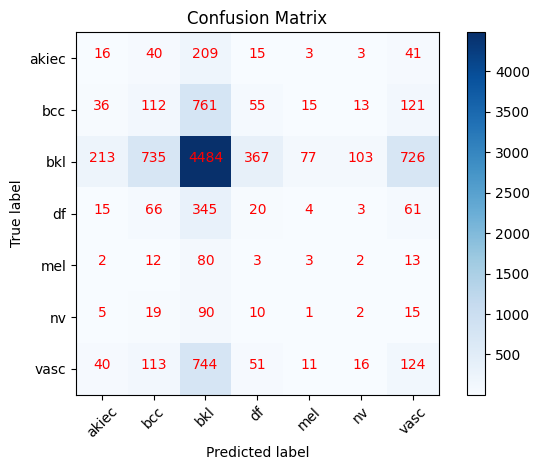

In [51]:
cm_plot_label = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
plot_confusion_matrix(cm=cm, classes=cm_plot_label, title='Confusion Matrix', text_color='red')